In [454]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sts
from scipy.stats import norm, ttest_ind, poisson

from tqdm.auto import tqdm

# Ускорение А/Б тестов и методы сокращения дисперсии
- Увеличение чувствительности экспериментов
- Чем уникальна ratio-метрика и как ее считать

> Увеличение чувствительности экспериментов при сохранении тех же параметров теста возможно за счет сокрашения дисперсии

> Также это позволит нам быстрее достичь нужной мощности и сократить время затрачиваемое на эксперимент

## Стратификация
- Один из методов соращения дисперсии
- Мы разбиваем аудиторию на группы (страты) по каким-то признакам (например, по типам устройств) или с определенной вероятностью. В каждой группе могут сильно отличаться средние и дисперсии. И в зависимости от важности или численности группы мы даем им больший или меньший вес.
    - Это позволит нам в меньшей степени учитывать высокую дисперсию в малых группах, а следовательно сократить дисперсию для всей выборки в целом
    
#### Стратификация (stratified sample)
На этапе дизайна эксперимента, разбиваем пользователей на k групп (страт), определяется вероятность попадания в страту

#### Пост-стратификация (post-stratification)
Получив рандомную выборку, применяется стратификация на основе заранее известных вероятностей попадания в страту

### Как считаем стратификацию
1. Выбираем критерий стратификации (тип устройства и пр.)
2. Считаем вер-ть попадания пользователя в страту
3. Считаем внутригрупповую дисперсию (внутри каждой страты)
4. Считаем взвешенную дисперсию

#### Классическая дисперсия состоит из внутригрупповой и межгрупповой дисперсии
- Внутригрупповая дисперсия -> считается как для стратификации
    - Внутри каждой страты считаем дисперсию
    - Умножаем дисперсию на вер-ть попадания в эту страту
    - Все суммируем
- Межгрупповая дисперсия
    - Внутри каждой страты считаем дисперсию
    - Внутри каждой страты считаем квадрат разности среднего страты и общего среднего)
    - Все суммируем
> В стратификации мы выбрасываем эффект межгрупповой дисперсии, что позволяет нам сократить ее

> Среднее стратифицированное равняется среднему Генеральной совокупности

### Выводы
- Страты должны быть стабильными и не меняться во времени
- Плохо подобранные переменные для стратификации влекут за собой увеличение дисперсии

### Сгенерим данные

In [315]:
def data_gen(n, mean, se, group=None, samples=1, salt=1):
    """
    n - размер выборки 
    mean - среднее по выборке
    se - стандартное отклонение по выборке
    group - добавить дополнительную колонку с описанием сэмпла
    samples - кол-во сэмплов
    salt - коэффициент для разницы между сэмплами
    """
    
    try:
        del distr_data
    except:
        pass
    
    for sample in range(samples):
        distribution = sts.norm.rvs(
            size=n[sample], 
            loc=mean[sample]*salt, 
            scale=se[sample]*salt)
        distribution = list(distribution)
        
        try:
            if group:
                distr_data['sample'] = distr_data['sample'] + [sample]*n[sample]
                distr_data['group'] = distr_data['group'] + [group]*n[sample]
                distr_data['variable'] = distr_data['variable'] + distribution
            else:
                distr_data['sample'] = distr_data['sample'] + [sample]*n[sample]
                distr_data['variable'] = distr_data['variable'] + distribution

        except:
            if group:
                distr_data = {
                    'sample': [sample]*n[sample],
                    'group': [group]*n[sample],
                    'variable': distribution
                }
            else: 
                distr_data = {
                    'sample': [sample]*n[sample],
                    'variable': distribution
                }

    df_distr = pd.DataFrame(distr_data)
    
    return df_distr

In [319]:
df_distr_test = data_gen(
    n=[12000, 6000, 2000], 
    mean=[15, 35, 58], 
    se=[20, 30, 40], 
    group='test', 
    samples=3,
    # salt=np.random.randint(50)
)
df_distr_control = data_gen(
    n=[12000, 6000, 2000], 
    mean=[12, 31, 64], 
    se=[17, 24, 54], 
    group='control', 
    samples=3,
    # salt=np.random.randint(50)
)

df_distr = pd.concat([df_distr_test, df_distr_control])
df_distr.head()

,sample,group,variable
0,0,test,-12.840206
1,0,test,29.775905
2,0,test,35.675066
3,0,test,4.758090
4,0,test,14.912017


### Как распределена метрика между группами

In [320]:
df_distr.groupby(['sample', 'group']).agg(['count', 'var', 'mean', 'median'])

variable                                   
                  count          var       mean     median
sample group                                              
0      control    12000   290.309367  11.818885  11.912562
       test       12000   405.191861  14.757865  14.639239
1      control     6000   579.858494  30.977131  31.047910
       test        6000   901.481952  34.915745  34.454970
2      control     2000  2817.375641  64.283784  64.127681
       test        2000  1661.679481  59.257831  59.510318

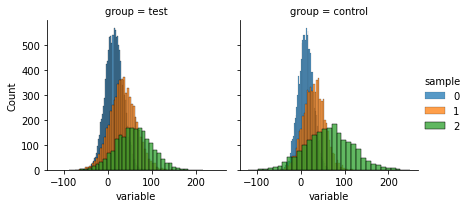

In [321]:
g = sns.FacetGrid(df_distr, col="group", hue="sample")
g.map_dataframe(sns.histplot, x="variable")
g.add_legend();

### Расчет среднего, дисперсии и вероятности попадания в страту

In [331]:
strat_stats = {}

sample_list = []
mean_list = []
var_list = []
strat_weight_list = []

for sample in list(set(df_distr['sample'])):
    sample_data = df_distr[df_distr['sample'] == sample]

    sample_list.append(sample)
    mean_list.append(sample_data['variable'].mean())
    var_list.append(sample_data['variable'].var())
    strat_weight_list.append(sample_data['variable'].count() / df_distr['variable'].count())
    
strat_stats['sample'] = sample_list
strat_stats['mean'] = mean_list
strat_stats['var'] = var_list
strat_stats['strat_weight'] = strat_weight_list

strat_stats_data = pd.DataFrame(strat_stats)
strat_stats_data

,sample,mean,var,strat_weight
0,0,13.288375,349.895615,0.6
1,1,32.946438,744.486988,0.3
2,2,61.770808,2245.284169,0.1


#### Расчет внутригрупповой дисперсии
Сумма дисперсий стат, умноженные на вероятности попадания в страту

In [333]:
ingroup_var = (strat_stats_data['strat_weight'] * strat_stats_data['var']).sum()
ingroup_var

657.8118823427831

#### Расчет межгрупповой дисперсии
Сумма вероятностей попадания в страту умнжоженных на разницу общего среднего и среднего страты в квадрате

In [336]:
total_mean = df_distr.variable.mean()

btw_group_var = (\
 strat_stats_data['strat_weight'] *\
(total_mean - strat_stats_data['mean'])**2\
).sum()
btw_group_var

235.51720338216066

#### Сумма внутригрупповой и межгрупповой дисперсии равны общей дисперсии

In [350]:
round(ingroup_var + btw_group_var, 1) == round(df_distr.variable.var(), 1)

True

## Cuped
- В Cuped мы смотрим не просто на бизнес-метрику, а на измененную, которая чувствительнее, благодаря ее связи с пред-экспериментальным периодом
    - Учитывается поведение пользователя до эксперимента (ковариата X) и во время эксперимента (фактическая метрика Y)
- После нахождения между этими метриками зависимости, уменьшается дисперсия → увеличивается чувствительность
- Таким образом, мы исключаем историческую дисперсию X (эффект сезонности и пр.) и оставляем только влияение пресущее самой метрике

$$
Y_{CUPED}=Y-\theta*X
$$
где,
- Y - метрика после эксперимента
- $\theta$ - уровень зависимости метрики от исторических данных
    - $\theta$ принимает значения от 0 до 1
    - чем выше $\theta$, тем выше связь метрик с историей и тем хуже мы можем оптимизировать дисперсию
$$
\theta = \frac{cov(X,Y)}{var(X)}
$$
- X - метрика до эксперимента (covariance). Для сохранения размерности среднего используется поправка на среднее
$$
X = covariance - mean(covariance)
$$
> Средняя и ковариата считается сразу для обеих групп вместе. Чтобы не быть подверженным возможным условиям эксперимента (несбалансированный трафик и пр.)

### Cuped имеет две модификации
- Пред-стратификация по категориальным переменным, например, регион, тип тарифа. пр.
- Ковариата - числовая непрерывная перемеенная взятая из истории пользователя *(как описали выше)*

### Почему в Cuped используется ковариация, а не корреляция?
- <b>Ковариация</b> - <i>абсолютная</i> мера близости двух величин
$$
cov(x,y) = \sum(x−x)̂*(y−y)̂
$$
- <b>Корреляция</b> - <i>относительная</i> мера близости двух величин
$$
r_{xy} = \frac{\sum_(x−x)̂*(y−y)̂}{\sqrt{\sum(x−x)̂^2*(y−y)̂^2}}
$$
> Значение корреляции имеет ниже размерность. Из-за этого она не смогла бы оказать достаточное виляние на ковариату

##### Кстати
> Ковариация двух равных величин равен дисперсии этой величины
$$
cov(x,x) = var(x)
$$

### Особенности Cuped
- Для ковариаты каждой метрики важно подбирать свой размер окна
- При этом окно ковариаты может время от времени меняться. И его периодически придется перевалидировать
- Подбор окна производится через А/А тест
    1. Выбираем метрику
    2. Замеряем метрику (Y)
    3. Считаем окна разной длины по этой метрике (ковариаты X)
    4. Сравниваем MDE в зависимости от мощности
        - Чем ниже MDE относительно мощности, тем лучше апроксимируется дисперсия

##### Важно: если метрика считается кумулятивно, то ковариата должна брать за тот же период

#### Сгенерим данные

In [399]:
# x - ковариата (историческая метрика)
# y - метрика в эксперименте

data = pd.DataFrame({
    'x': np.random.randint(50,80,1000),
    'y': np.random.randint(55,85,1000)
})
data.head()

,x,y
0,61,66
1,51,57
2,78,62
3,60,60
4,70,62


In [400]:
data.agg(['mean', 'median', 'var'])

,x,y
mean,63.967000,69.636000
median,63.000000,70.000000
var,74.150061,71.681185


In [401]:
def cuped(covariate, metric):
    '''
    covariate - ковариата (историческая метрика)
    metric - метрика в эксперименте
    '''
    return metric - (covariate.cov(metric) / covariate.var()) * (covariate - covariate.mean())

In [402]:
data['y_cuped'] = cuped(data.x, data.y)

In [403]:
data.head()

,x,y,y_cuped
0,61,66,65.831815
1,51,57,56.264962
2,78,62,62.795464
3,60,60,59.775130
4,70,62,62.341982


In [404]:
# Дисперсия y_cuped ниже, чем у Y
data.agg(['mean', 'median', 'var'])

,x,y,y_cuped
mean,63.967000,69.636000,69.636000
median,63.000000,70.000000,69.738779
var,74.150061,71.681185,71.442925


#### Для оценки влияния Cuped на скорость сходимости дисперсии (и, соответственно, на скорость эксперимента), сравним как ведут себя дисперсии метрики и cuped метрики на разных наборах наблдений
> Можно заметить, что разница минимальна. Это говорит о том, что Cuped не всегда позволяет значимо сократить дисперсию

In [521]:
data_cumstd = pd.DataFrame()
data_cumstd['y_cumstd'] = data.y.expanding(2).std()
data_cumstd['y_cuped_cumstd'] = data.y_cuped.expanding(2).std()
data_cumstd.head()

,y_cumstd,y_cuped_cumstd,index
0,NaN,NaN,0
1,6.363961,6.764786,1
2,4.509250,4.888619,2
3,3.774917,4.097954,3
4,3.286335,3.587633,4


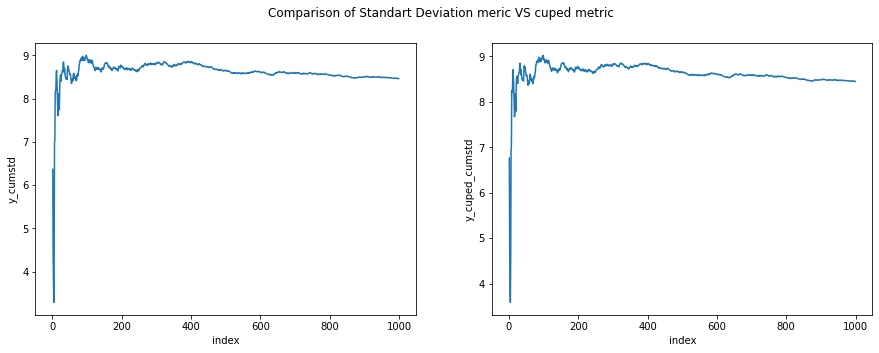

In [538]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Comparison of Standart Deviation meric VS cuped metric')

sns.lineplot(
    data=data_cumstd,
    x='index',
    y='y_cumstd',
    ax=axes[0]
);
sns.lineplot(
    data=data_cumstd,
    x='index',
    y='y_cuped_cumstd',
    ax=axes[1]
);

## Ratio-метрики
> Ratio-метрика – это отношение одной случайной величины к другой. Например, клики к просмотрам или клики к сессиям

##### Какие есть особенности данного типа метрик?
- Дисперсия
    <br>У каждой из величин в ratio-метрике будет своя дисперсия. И этот эффект важно учитывать
- Ratio-метрику нельзя представить как бинарную (т.к. перед использованием критерия попадем в проблему с зависимостью наблюдений)
- Влияние весов (CTR 1% может представлен как 1/100 или 100/10000)

##### Как брать среднее для ratio-метрик?
- Нельзя считать ratio поюзерно, а потом брать их среднее. Этот метод рассчета вызывает смещение от отношения каждой из сумм
- Правильно брать поюзерную сумму по числителю, поюзерную сумму по знаменателю и затем считать их отношение 

#### Методы работы с Ratio
- Бутстрап
- Дельта-метод
- Линеаризация

### Бутстрап
1. Считаем подвыборку ratio-метрики в тесте и контроле
2. Полученные значения умножаем на их вес (на знаменатель), чтобы сократить смещение (bias)
3. Считаем разницу метрик (тест-конроль)
4. Полученное распределение разностей метрик можно дальше анализировать

#### Другой, более популярный случай, применения бутстрапа для ratio - Пуасоновский Бутстрап
> Распределение Пуассона с лямбдой равной единице приближенно к биномиальному. Полученные дискретные значения представляются в виде случаев, как будто бы мы делали многократные семплирования количества пользователей, которые встречаются в выборке. Так значительно ускоряются вычисления, т.к. не требуется делать 1000 операций, а лишь 1.

1. Генерируем распределение Пуассона с лямбдой = 1
2. Значения отношений умножаем на их вес (в данном случае это знаменатель), чтобы избежать bias
3. Отношения умножаем на значения Пуассона
4. Считаем разницу и получаем распределение разницы метрики-отношения контроля и теста

#### Посмотрим как выглядит Паусоновское распределение и как Паусоновское распределение с лямбдой 1 апроксимрует биномиальное распределение

In [475]:
p1 = poisson(1).rvs(1000)
p5 = poisson(5).rvs(1000)
b = sts.binom(1000, 1/1000).rvs(1000)

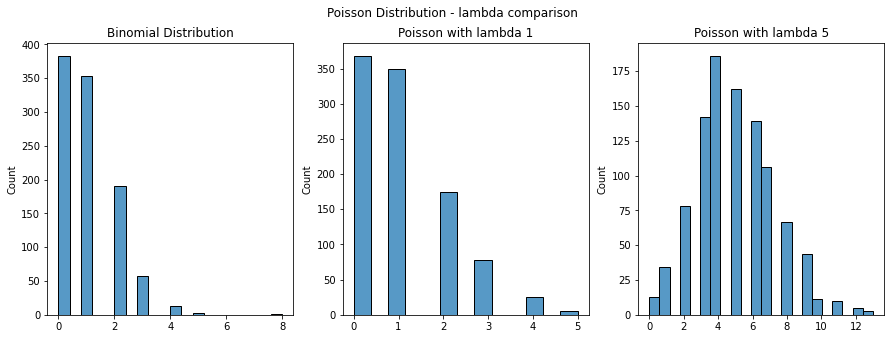

In [478]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Poisson Distribution - lambda comparison')

sns.histplot(ax=axes[0], x=b)
axes[0].set_title('Binomial Distribution')
sns.histplot(ax=axes[1], x=p1)
axes[1].set_title('Poisson with lambda 1')
sns.histplot(ax=axes[2], x=p5)
axes[2].set_title('Poisson with lambda 5');

In [ ]:
def bootstrap_poisson(rto0, w0, rto1, w1, boot_it=500):
    """
    Пуассоновский бутстрап
    :param rto0: Рассчитанное ratio для левого сплита
    :param w0: Знаменатель rto0
    :param rto1: Рассчитанное ratio для правого сплита
    :param w1: Знаменатель rto1
    :param boot_it: количество бут итераций
    :return: pvalue
    """
    
    poisson_0 = poisson(1).rvs((boot_it, rto0.size)).astype(np.int64)
    poisson_1 = poisson(1).rvs((boot_it, rto1.size)).astype(np.int64)

    rto1 = np.matmul(rto1 * w1, poisson_1.T)

    w1 = np.matmul(w1, poisson_1.T)

    rto0 = np.matmul(rto0 * w0, poisson_0.T)
    w0 = np.matmul(w0, poisson_0.T)
    
    delta = rto1 / w1 - rto0 / w0
    
    positions = np.sum(delta < 0)

    pvalue = 2 * np.minimum(positions, boot_it - positions) / boot_it
    return pvalue

### Delta-метод
Delta-метод позволяет получить апроксимированное значение дисперсии для любой случайной величины, в том числе и для ratio.
Для этого дисперсия преобразовывается с помощью ряда Тейлора

In [ ]:
def deltamethod(x_0, y_0, x_1, y_1):
    n_0 = y_0.shape[0]-1
    n_1 = y_0.shape[0]-1

    mean_x_0, var_x_0 = np.mean(x_0), np.var(x_0)
    mean_x_1, var_x_1 = np.mean(x_1), np.var(x_1)

    mean_y_0, var_y_0 = np.mean(y_0), np.var(y_0)
    mean_y_1, var_y_1 = np.mean(y_1), np.var(y_1)

    cov_0 = np.mean((x_0 - mean_x_0.reshape(-1, )) * (y_0 - mean_y_0.reshape(-1, )))
    cov_1 = np.mean((x_1 - mean_x_1.reshape(-1, )) * (y_1 - mean_y_1.reshape(-1, )))

    var_0 = var_x_0 / mean_y_0 ** 2 + var_y_0 * mean_x_0 ** 2 / mean_y_0 ** 4 - 2 * mean_x_0 / mean_y_0 ** 3 * cov_0
    var_1 = var_x_1 / mean_y_1 ** 2 + var_y_1 * mean_x_1 ** 2 / mean_y_1 ** 4 - 2 * mean_x_1 / mean_y_1 ** 3 * cov_1

    rto_0 = np.sum(x_0) / np.sum(y_0)
    rto_1 = np.sum(x_1) / np.sum(y_1)

    statistic = (rto_1 - rto_0) / np.sqrt(var_0 / n_0 + var_1 / n_1)
    pvalue = 2 * np.minimum(norm(0, 1).cdf(statistic), 1 - norm(0, 1).cdf(statistic))
    return pvalue

### Линеаризация
С помощью линеаризации мы хотим понять отклонение метрики в эксперименте относительно ratio в контроле

In [ ]:
def linearization(x_0, y_0, x_1, y_1):
    k = x_0.sum() / y_0.sum()
    l_0 = x_0 - k * y_0
    l_1 = x_1 - k * y_1
    return l_0, l_1